<a href="https://colab.research.google.com/github/aamyren/TF-training/blob/main/Multi-Digit_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.8.2


In [ ]:
# helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# x_train.shape

In [ ]:
# function to combine two indexes of data in each list
def combine(xdata, ydata, a, b):
    ny = int(10*ydata[a] + ydata[b])
    nx = np.hstack((xdata[a],xdata[b]))
    nx = nx[:, ::2]
    # print(ny)
    return nx, ny

In [ ]:
# creates list of random indexes a certain length to combine
def randlist(size):
    rlist = list(range(size))
    random.shuffle(rlist)
    return rlist

In [ ]:
# y_test.shape

In [ ]:
# make a new set of test cases for double digits
nx_test = np.empty((10000, 28, 28, 1))
ny_test = np.empty(10000)

a = randlist(10000)
for i in range(0, 10000):
    x, y = combine(x_test, y_test, a[i], a[i-1])
    ny_test[i] = y 
    nx_test[i] = x

#print(ny_test)

# also make a new set of training data for double digits
nx_train = np.empty((60000, 28, 28, 1))
ny_train = np.empty(60000)

a = randlist(60000)
for i in range(0, 60000):
    x, y = combine(x_train, y_train, a[i], a[i-1])
    ny_train[i] = y 
    nx_train[i] = x

#print(ny_test)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (nx_train, ny_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((nx_test, ny_test)).batch(32)

In [ ]:
# set up neural network

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(100)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.7827661633491516, Accuracy: 78.00166320800781, Test Loss: 0.2938455045223236, Test Accuracy: 91.00999450683594
Epoch 2, Loss: 0.2245214879512787, Accuracy: 93.12000274658203, Test Loss: 0.2225283533334732, Test Accuracy: 92.77999877929688
Epoch 3, Loss: 0.1322445124387741, Accuracy: 95.87000274658203, Test Loss: 0.2153508961200714, Test Accuracy: 93.37000274658203
Epoch 4, Loss: 0.08499730378389359, Accuracy: 97.25333404541016, Test Loss: 0.21937280893325806, Test Accuracy: 93.62000274658203
Epoch 5, Loss: 0.05817937105894089, Accuracy: 98.07833099365234, Test Loss: 0.22062212228775024, Test Accuracy: 93.91000366210938


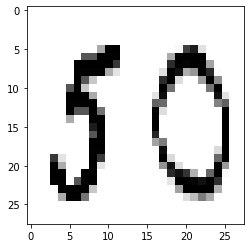

In [ ]:
# checking some training data how it looks
nx_train = np.resize(nx_train, (60000, 28, 28))
plt.figure()
plt.imshow(nx_train[10000], cmap = plt.cm.binary)

In [ ]:
#nx_train.shape

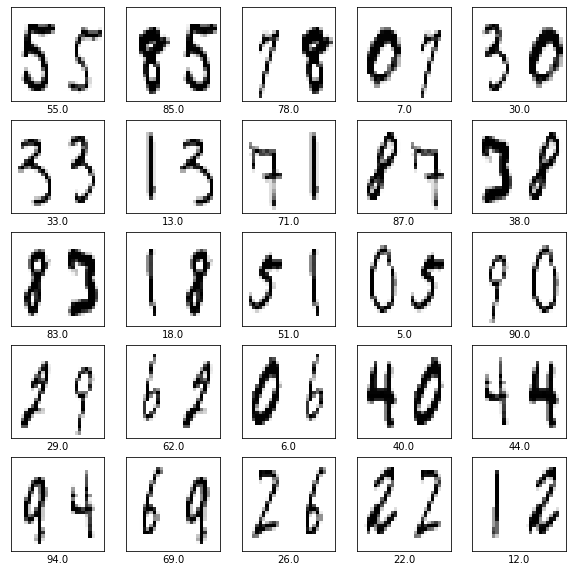

In [ ]:
# more checking
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nx_train[i], cmap=plt.cm.binary)
    plt.xlabel(ny_train[i])
plt.show()

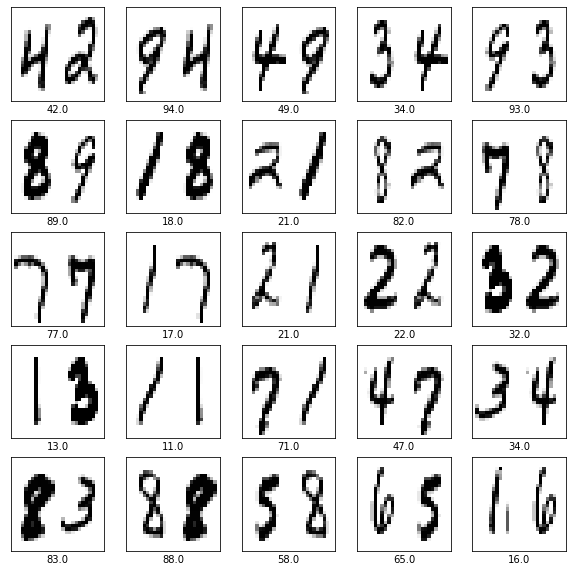

In [ ]:
# checking how test data looks
nx_test = np.resize(nx_test, (60000, 28, 28))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(nx_test[i], cmap=plt.cm.binary)
    plt.xlabel(ny_test[i])
plt.show()

In [ ]:
# getting predictions
nx_test = np.resize(nx_test, (60000, 28, 28, 1))
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(nx_test)
#predictions[0]

In [ ]:
# predictions.shape

In [ ]:
# np.argmax(predictions[420])

18


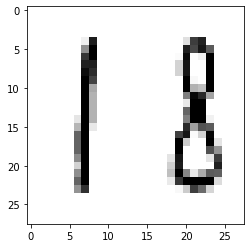

In [ ]:
# checking test data manually w/ predictions

nx_test = np.resize(nx_test, (60000, 28, 28))
plt.figure()
plt.imshow(nx_test[444], cmap = plt.cm.binary)
print(np.argmax(predictions[444]))